# Non - Resampling Method Validation (10-07-2024)

Objective: To test the preprocessing pipeline, checking if the code is working well without the assumption that the timeseries has even intervals.

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append('/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/STEP9_DATA_MODELLING_AND_EXPLORATION')
sys.path.append('/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/DATASETS')
#import xgboost as xgb
from sklearn.pipeline import Pipeline

from PreprocessData import * # import from custom transformers 

## Testing the fire preprocessing stuff

In [2]:
smaller_subset = pd.read_csv('../DATASETS/Sites_Subset_20231010/ausplots_site_info/sites_subset.csv').copy()
sites_list = list(np.unique(smaller_subset.site_location_name.values))
historical_fire_ds = pd.read_csv('../DATASETS/AusPlotsBurnData/Combined_Data/AusPlots_Combined_Fire_Dataset.csv', parse_dates = ['ignition_d']) # Fire Dataset
site_info =  pd.read_csv('C:/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/DATASETS/AusPlots_Extracted_Data/Final/extracted_Final_site_info_2-0-6.csv',
                             index_col = 0).copy() 

In [3]:
max_counter = len(sites_list)
counter = 1
print(f'The Data Awaiting Preprocessing: {sites_list}')
preprocess_data = True
for site_location_name in [sites_list[2]]:
    
    skip_preprocess = False 
    
    print(f'Processing Data for {site_location_name}, {counter}/{max_counter}')
    
    time_lag = 1
    window_length = 5
    time_range = 3
    
    # savgol_filter parameters 
    window_length_smooth = 15
    polyorder = 4 
    
    # Preprocess fire dataset
    historical_fire_pipeline = Pipeline([
        ('historical_burn_date_preprocess', historical_burn_date_preprocess(site_location_name))
        ])
    historical_fire_ds_site = historical_fire_pipeline.fit_transform(historical_fire_ds)
    
    # Get Latitude of Site to derive daylength 
    site_specific_info = site_info[site_info['site.info.site_location_name'] == site_location_name]
    latitude = site_specific_info['site.info.latitude'][site_specific_info.index[0]] # only need the first entry
    
    # Get the FC time series of the site 
    try:
        site = pd.read_csv(f'../DATASETS/DEA_FC_PROCESSED/SPATIAL_AND_UE_FILTER/{site_location_name}.csv', parse_dates=['time'])
    except:
        site_log.loc[site_log.index == site_location_name,'Error'] += '4'
        skip_preprocess = True 
        print('Error 4')

    if skip_preprocess == True:
        continue # skip this loop iteration 
         
    if preprocess_data == True:
    # Preprocess FC time series, add daylength and fire information
        time_fc_pipeline = Pipeline([
            ('preprocess_fc_time_series', preprocess_fc_time_series(window_length = window_length_smooth, polyorder = polyorder)),
            ('time_attributes_adder', time_attributes_adder()),
            ('time_attributes_fc_lag_adder', time_attributes_fc_lag_adder(time_lag)),
            ('time_attributes_fc_diff_adder', time_attributes_fc_diff_adder(False)),
            ('daylength_attributes_adder', daylength_attributes_adder(latitude)),
            ('historical_burn_date_attribute_adder', historical_burn_date_attribute_adder(historical_fire_ds_site)),
            ('historical_burn_date_index_attribute_adder', historical_burn_date_index_attribute_adder(verbose = False,
                                                                                                      historical_fire_ds = historical_fire_ds_site,
                                                                                                      time_range = time_range)),
         ])
        site_resampled = time_fc_pipeline.fit_transform(site)
        print('FC and fire data successfully preprocessed')
        counter += 1
        break

The Data Awaiting Preprocessing: ['NSABHC0023', 'NSAMDD0014', 'NSANAN0002', 'NSANSS0001', 'NTAFIN0002', 'NTAGFU0021', 'QDAEIU0010', 'QDASSD0015', 'SATSTP0005', 'TCATCH0006', 'WAAGAS0002', 'WAAPIL0003']
Processing Data for NSANAN0002, 1/12
FC and fire data successfully preprocessed


C:\Users\krish\Desktop\DYNAMIC MODEL VEGETATION PROJECT\au_dyanamic_vegetation_project\STEP9_DATA_MODELLING_AND_EXPLORATION\PreprocessData.py:575: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['fire_severity'] = X['fire_severity'].replace(pd.NA, 0) # set all records prior to the first fire to 0


<Axes: xlabel='time'>

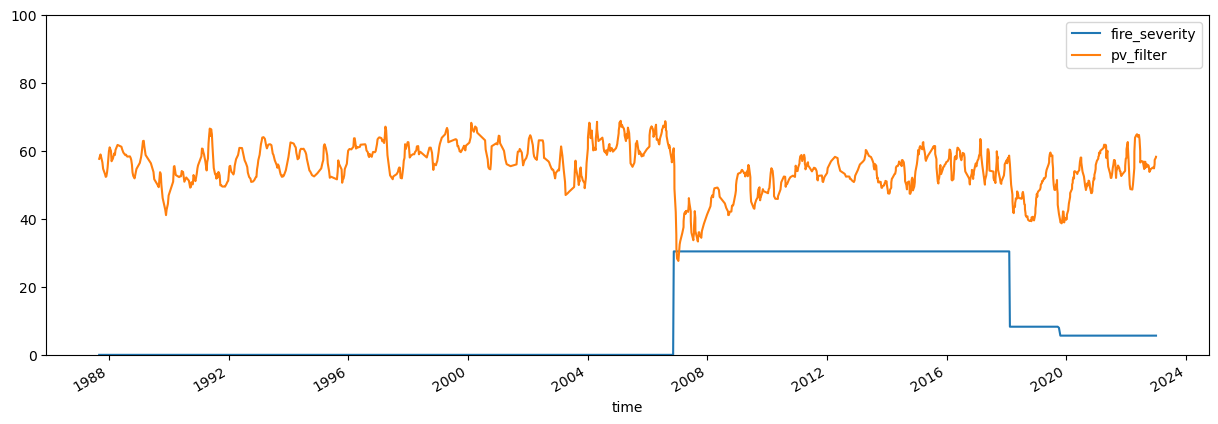

In [4]:
site_resampled.plot(y = ['fire_severity', 'pv_filter'], ylim = [0,100], figsize = (15,5))

Checking the days since fire attribute:

In [5]:
historical_fire_ds_site

,ignition_d,extinguish,site_location_name
0,2006-11-14,2007-01-18,NSANAN0002
1,2018-02-11,2018-03-01,NSANAN0002
2,2019-10-01,NaT,NSANAN0002
3,2019-10-16,2019-12-03,NSANAN0002


In [6]:
(historical_fire_ds_site.at[1,'ignition_d'] - historical_fire_ds_site.at[0,'ignition_d']).days 

4107

This seems correct:

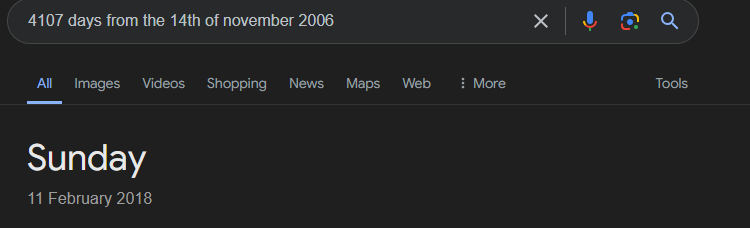

Check if this is reflected well in the dataset:

In [7]:
site_resampled.loc[(site_resampled.index <= historical_fire_ds_site.at[1,'ignition_d']) & 
                   (site_resampled.index >= historical_fire_ds_site.at[0,'ignition_d'])]

,Unnamed: 0,pv,npv,bs,ue,x,y,spatial_ref,pv_filter,npv_filter,...,pv_lag,npv_lag,bs_lag,pv_change,npv_change,bs_change,photoperiod,photoperiod_gradient,days_since_fire,fire_severity
time,,,,,,,,,,,,,,,,,,,,,
2006-11-16,555,57.454545,39.409091,1.545455,23.409091,1.721596e+06,-3.417427e+06,3577,60.753532,34.115656,...,59.880743,32.312024,6.121233,1.493939,5.171212,-6.793939,13.643905,0.022960,2,30.423417
2006-11-17,556,60.227273,36.000000,2.318182,22.681818,1.721596e+06,-3.417427e+06,3577,59.513429,36.162425,...,60.753532,34.115656,3.493667,-0.590909,2.045455,-1.340909,13.666464,0.022558,3,30.423417
2006-11-24,557,59.409091,35.500000,3.318182,22.318182,1.721596e+06,-3.417427e+06,3577,55.453017,37.217897,...,59.513429,36.162425,2.777366,0.977273,-1.954545,0.886364,13.811959,0.019359,10,30.423417
2006-11-25,558,57.181818,35.409091,5.636364,20.909091,1.721596e+06,-3.417427e+06,3577,48.826340,37.833634,...,55.453017,37.217897,5.787357,-1.522727,-0.295455,1.659091,13.830805,0.018846,11,30.423417
2006-12-11,559,36.000000,39.600000,23.200000,14.600000,1.721637e+06,-3.417459e+06,3577,41.988579,40.850315,...,48.826340,37.833634,11.817173,-11.704545,2.050000,9.940909,14.051992,0.008915,27,30.423417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-25,984,59.000000,28.000000,12.000000,25.000000,1.721625e+06,-3.417465e+06,3577,57.245265,32.828583,...,57.601541,32.251175,8.517277,1.522727,-2.704545,1.727273,13.700174,-0.021646,4090,30.423417
2018-01-26,985,61.318182,28.636364,8.136364,20.000000,1.721596e+06,-3.417427e+06,3577,58.040625,30.991558,...,57.245265,32.828583,8.226856,2.568182,-5.181818,2.477273,13.678080,-0.022094,4091,30.423417
2018-02-02,986,54.272727,28.363636,15.545455,20.409091,1.721596e+06,-3.417427e+06,3577,58.606716,28.656314,...,58.040625,30.991558,9.308491,-2.363636,0.181818,1.772727,13.512022,-0.024850,4098,30.423417


<Axes: xlabel='time'>

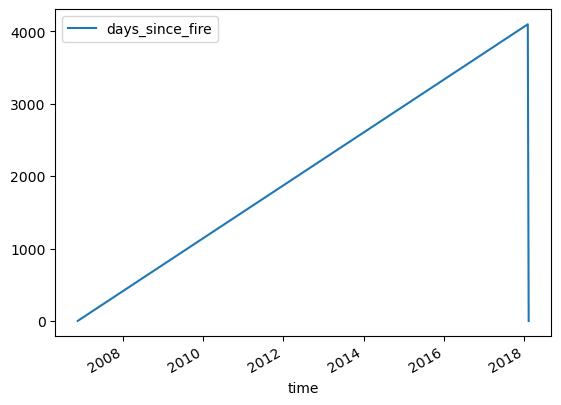

In [8]:
site_resampled.loc[(site_resampled.index <= historical_fire_ds_site.at[1,'ignition_d']) & 
                   (site_resampled.index >= historical_fire_ds_site.at[0,'ignition_d'])].plot(y = 'days_since_fire')

The beginning and end of the time points are consistent with the known difference in days.

## Check Photoperiod

<Axes: xlabel='time'>

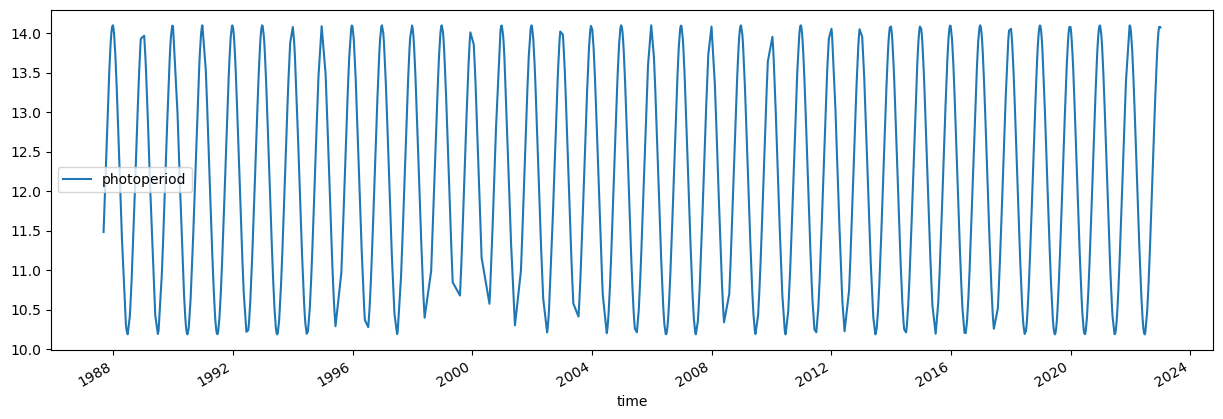

In [9]:
site_resampled.plot(y = ['photoperiod'], figsize = (15,5))

<Axes: xlabel='time'>

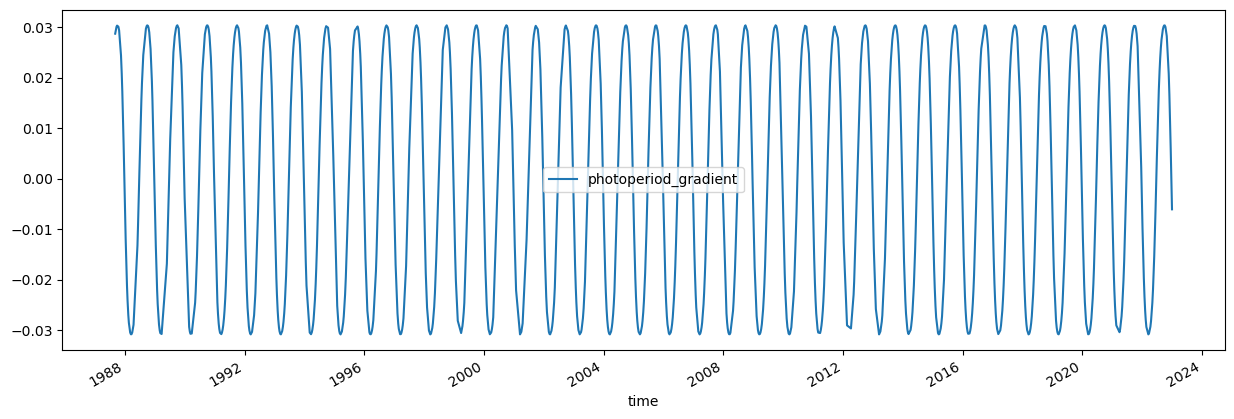

In [10]:
site_resampled.plot(y = ['photoperiod_gradient'], figsize = (15,5)) 

## Check Page's Climate variables 

In [11]:
smaller_subset = pd.read_csv('../DATASETS/Sites_Subset_20231010/ausplots_site_info/sites_subset.csv').copy()
sites_list = list(np.unique(smaller_subset.site_location_name.values))
historical_fire_ds = pd.read_csv('../DATASETS/AusPlotsBurnData/Combined_Data/AusPlots_Combined_Fire_Dataset.csv', parse_dates = ['ignition_d']) # Fire Dataset
site_info =  pd.read_csv('C:/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/DATASETS/AusPlots_Extracted_Data/Final/extracted_Final_site_info_2-0-6.csv',
                             index_col = 0).copy() 

In [12]:
max_counter = len(sites_list)
counter = 1
print(f'The Data Awaiting Preprocessing: {sites_list}')
preprocess_data = True

for site_location_name in [sites_list[0]]:    
    skip_preprocess = False 
    
    print(f'Processing Data for {site_location_name}, {counter}/{max_counter}')
    
    time_lag = 1
    window_length = 5
    time_range = 3
    
    # savgol_filter parameters 
    window_length_smooth = 15
    polyorder = 4 
    
    # Preprocess fire dataset
    historical_fire_pipeline = Pipeline([
        ('historical_burn_date_preprocess', historical_burn_date_preprocess(site_location_name))
        ])
    historical_fire_ds_site = historical_fire_pipeline.fit_transform(historical_fire_ds)
    
    # Get Latitude of Site to derive daylength 
    site_specific_info = site_info[site_info['site.info.site_location_name'] == site_location_name]
    latitude = site_specific_info['site.info.latitude'][site_specific_info.index[0]] # only need the first entry
    
    # Get the FC time series of the site 
    try:
        site = pd.read_csv(f'../DATASETS/DEA_FC_PROCESSED/SPATIAL_AND_UE_FILTER/{site_location_name}.csv', parse_dates=['time'])
    except:
        skip_preprocess = True 
        print('Error 4')

    if skip_preprocess == True | preprocess_data == False:
        print(f'Data for {site_location_name} SKIPPED  {counter}/{max_counter}')
        counter += 1
        continue # skip this loop iteration 
         
    # Preprocess FC time series, add daylength and fire information
    time_fc_pipeline = Pipeline([
        ('preprocess_fc_time_series', preprocess_fc_time_series(window_length = window_length_smooth, polyorder = polyorder)),
        ('time_attributes_adder', time_attributes_adder()),
        ('time_attributes_fc_lag_adder', time_attributes_fc_lag_adder(time_lag)),
        ('time_attributes_fc_diff_adder', time_attributes_fc_diff_adder(False)),
        ('daylength_attributes_adder', daylength_attributes_adder(latitude)),
        ('historical_burn_date_attribute_adder', historical_burn_date_attribute_adder(historical_fire_ds_site)),
        ('historical_burn_date_index_attribute_adder', historical_burn_date_index_attribute_adder(verbose = False,
                                                                                                  historical_fire_ds = historical_fire_ds_site,
                                                                                                  time_range = time_range))
         ])
    site_resampled = time_fc_pipeline.fit_transform(site)
    
    print('FC and fire data successfully preprocessed')
    # Used to add climate attributes directly from AGCD 
    precip = pd.read_csv(f'../DATASETS/Climate_Gridded/precip/{site_location_name}_1980_2022.csv', parse_dates=['time'], usecols = ['time', 'precip'])
    tmin = pd.read_csv(f'../DATASETS/Climate_Gridded/tmin/{site_location_name}_1980_2022.csv', parse_dates=['time'],  usecols = ['time', 'tmin'])
    tmax = pd.read_csv(f'../DATASETS/Climate_Gridded/tmax/{site_location_name}_1980_2022.csv', parse_dates=['time'],  usecols = ['time', 'tmax'])
    vapourpres_h09 = pd.read_csv(f'../DATASETS/Climate_Gridded/vapourpres_h09/{site_location_name}_1980_2022.csv', parse_dates=['time'],  usecols = ['time', 'vapourpres_h09'])
    vapourpres_h15 = pd.read_csv(f'../DATASETS/Climate_Gridded/vapourpres_h15/{site_location_name}_1980_2022.csv', parse_dates=['time'], usecols = ['time', 'vapourpres_h15'])
    
    # Now merge everying as climate data 
    # Note: the proceeding indented line continues from the previous one as indicated by '.\'
    climate_data = tmin.merge(tmax, left_on = 'time', right_on = 'time').merge(vapourpres_h09, left_on = 'time', right_on = 'time').\
        merge(vapourpres_h15, left_on = 'time', right_on = 'time').merge(precip, left_on = 'time', right_on = 'time').sort_values('time')
    climate_data = climate_data.sort_values('time')
    climate_data = climate_data.set_index('time')
    
    # Derive Climate Variables from preprocessed AGCD time series 
    derive_climate_vars_pipeline = Pipeline([
            ('mean_annual_variables_adder', mean_annual_variables_adder(climate_data)),
            ('pages_precip_variables_adder', pages_precip_variables_adder(climate_data, False)),
            ('pages_VPD_variables_adder', pages_VPD_variables_adder(climate_data, False)),
            ('pages_temp_variables_adder', pages_temp_variables_adder(climate_data, True))
        ])
    site_resampled = derive_climate_vars_pipeline.fit_transform(site_resampled)
    site_merged = site_resampled.copy()  
    print(f'Data for {site_location_name} Exported  {counter}/{max_counter}')
    counter += 1

The Data Awaiting Preprocessing: ['NSABHC0023', 'NSAMDD0014', 'NSANAN0002', 'NSANSS0001', 'NTAFIN0002', 'NTAGFU0021', 'QDAEIU0010', 'QDASSD0015', 'SATSTP0005', 'TCATCH0006', 'WAAGAS0002', 'WAAPIL0003']
Processing Data for NSABHC0023, 1/12
No Fire Dates for NSABHC0023 avaliable
FC and fire data successfully preprocessed
MAT: 19.583609095952998, MAP: 228.4221929505814
Passed:
From t(1) to t(1)
From Index(2811) to Index(2810)
From t(1987-09-11 00:00:00) to t(1987-09-11 00:00:00)
DatetimeIndex(['1987-09-11'], dtype='datetime64[ns]', name='time', freq=None)
[20.82226562]
1
20.822265625
Passed:
From t(2) to t(7)
From Index(2810) to Index(2804)
From t(1987-09-05 00:00:00) to t(1987-09-10 00:00:00)
DatetimeIndex(['1987-09-05', '1987-09-06', '1987-09-07', '1987-09-08',
               '1987-09-09', '1987-09-10'],
              dtype='datetime64[ns]', name='time', freq=None)
[13.23242188 14.20214844 16.65234375 18.79199219 20.08203125 16.15234375]
6
99.11328125
Passed:
From t(8) to t(14)
From Ind

C:\Users\krish\Desktop\DYNAMIC MODEL VEGETATION PROJECT\au_dyanamic_vegetation_project\STEP9_DATA_MODELLING_AND_EXPLORATION\PreprocessData.py:264: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climate_var['Index'] = list(range(len(climate_var.index)))
C:\Users\krish\Desktop\DYNAMIC MODEL VEGETATION PROJECT\au_dyanamic_vegetation_project\STEP9_DATA_MODELLING_AND_EXPLORATION\PreprocessData.py:264: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climate_var['Index'] = list(range(len(climate_var.index)))
C:\Users

In [13]:
site_resampled

,Unnamed: 0,pv,npv,bs,ue,x,y,spatial_ref,pv_filter,npv_filter,...,VPD_14,VPD_30,tmax_lag,tmax_7,tmax_14,tmax_30,tmin_lag,tmin_7,tmin_14,tmin_30
time,,,,,,,,,,,,,,,,,,,,,
1987-09-12,1,27.56,43.48,27.72,9.68,954195.0,-3451725.0,3577,30.084996,40.527417,...,4.349122,9.298999,20.822266,99.113281,121.859375,285.723633,3.886719,44.521484,47.457031,109.269531
1987-09-21,2,24.72,39.88,34.04,8.72,954195.0,-3451725.0,3577,23.000585,44.768602,...,4.963419,10.253317,21.662109,145.221680,134.755859,280.832031,10.907227,48.422852,43.167969,122.422852
1987-09-28,3,25.76,49.40,23.60,10.20,954195.0,-3451725.0,3577,19.754155,45.181257,...,8.562410,9.716372,32.952148,181.522461,166.883789,284.049805,17.537109,75.852539,59.330078,109.869141
1987-10-07,4,18.20,39.08,41.44,8.64,954195.0,-3451725.0,3577,18.804125,43.744107,...,16.575162,16.463244,30.130859,140.336914,218.415039,351.943359,11.007812,62.248047,106.279297,120.461914
1987-10-14,5,13.28,38.28,47.08,6.68,954195.0,-3451725.0,3577,18.912159,42.005756,...,9.746282,28.074986,20.531250,139.375977,170.467773,435.602539,8.288086,61.677734,73.255859,183.573242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-03,1597,25.64,42.68,30.56,9.36,954195.0,-3451725.0,3577,24.601844,42.379749,...,11.688541,20.601776,31.769531,176.050781,191.967773,425.065430,15.585938,93.721680,91.574219,214.162109
2022-12-10,1598,23.48,43.52,31.64,9.48,954195.0,-3451725.0,3577,23.919617,43.233760,...,13.592410,23.043878,25.820312,187.639648,207.820312,429.994141,11.055664,104.946289,109.307617,220.495117
2022-12-19,1599,21.48,42.28,34.68,8.64,954195.0,-3451725.0,3577,23.002862,44.254158,...,15.854423,30.460166,32.910156,159.439453,217.150391,468.217773,19.286133,71.936523,111.891602,236.774414


<Axes: xlabel='time'>

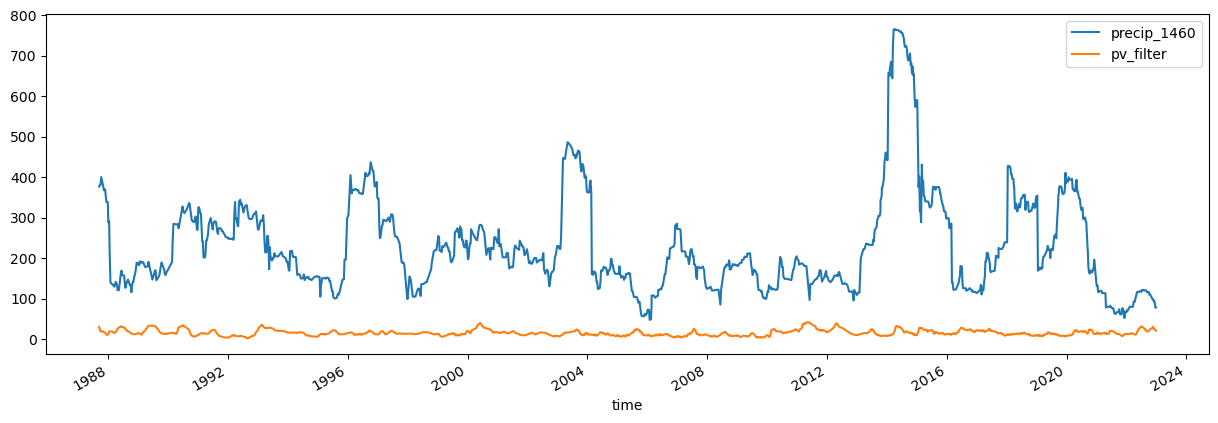

In [14]:
site_merged.plot(y = ['precip_1460', 'pv_filter'], figsize = (15,5))

<Axes: xlabel='time'>

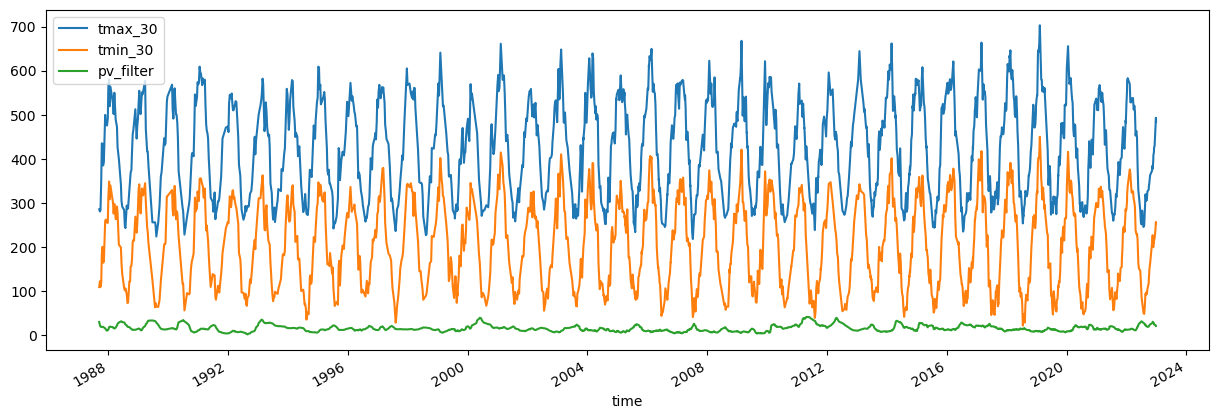

In [17]:
site_merged.plot(y = ['tmax_30', 'tmin_30', 'pv_filter'], figsize = (15,5))

<Axes: xlabel='[VPD_7]', ylabel='[pv_filter]'>

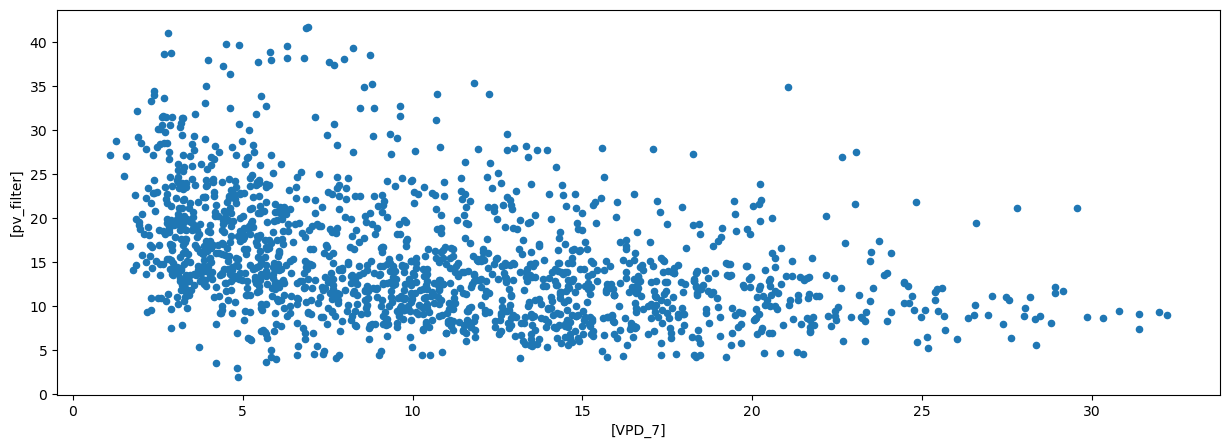

In [35]:
site_merged.plot.scatter(x = ['VPD_7'], y = ['pv_filter'], figsize = (15,5))

In [16]:
test[:,0]

array([1, 4, 7])